# Setup

In [1]:
import sys
import os

sys.path.append('..')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from custom_metrics import *

## Utility functions

In [2]:
# Utility function to extract bits of info on a run from its filename
def get_run_info_from_fname(filename):
    bits = filename.split('_')

    model = bits[0]
    assert bits[0] in ['pymer', 'FLAML', 'dummy'], f'Model "{bits[0]}" is not currently implemented in this function'
    
    if model == 'pymer':
        model_name = bits[0 : 4]
        i = 4
    elif model == 'FLAML':
        if ('rebalance' in filename) or ('tune' in filename) or ('ensemble' in filename):
            model_name = bits[0 : 4]
            i = 4
        else:
            model_name = bits[0 : 3]
            i = 3
    elif model == 'dummy':
        model_name = bits[0 : 2]
        i = 2
    model_name = '_'.join(model_name)

    if bits[i + 1] == 'extended':
        dataset = bits[i : i + 2]
        dataset = '_'.join(dataset)
        i += 2
    else:
        dataset = bits[i]
        i += 1
    
    num_folds = bits[i]
    num_folds = int(num_folds.removesuffix('-fold'))
    i += 1

    block_type = bits[i]
    block_type = block_type.removesuffix('.csv').removesuffix('-blocking')
    i += 1

    spatial_spacing = None
    group_col = None
    
    if block_type == 'spatial':
        spatial_spacing = bits[i]
        spatial_spacing = int(spatial_spacing.removesuffix('-degree.csv'))
    elif block_type == 'group':
        group_col = bits[i]
        group_col = group_col.removesuffix('.csv')

    return_dict = {'model_name' : model_name, 
                   'dataset' : dataset, 
                   'num_folds' : num_folds, 
                   'block_type' : block_type,
                   'spatial_spacing' : spatial_spacing,
                   'group_col' : group_col,
                   'filename' : filename}

    return return_dict

In [6]:
# Utility function to apply a metric by fold and then get avg/standard dev over folds
def get_metric_CV(raw_preds, metric, submodel = None, **kwargs):
    if submodel == 'nonzero':
        raw_preds = raw_preds[raw_preds['actual'] != 0].copy(deep = True) # tossing zero entries
    raw_preds = raw_preds.groupby('fold')

    if submodel is None:
        metric_by_group = raw_preds.apply(lambda x: metric(x['actual'], x['predicted'], **kwargs), include_groups = False)
    elif submodel == 'zero':
        metric_by_group = raw_preds.apply(lambda x: metric(x['actual_zero'], x['predicted_zero'], **kwargs), include_groups = False)
    elif submodel == 'nonzero':
        metric_by_group = raw_preds.apply(lambda x: metric(x['actual'], x['predicted_nonzero'], **kwargs), include_groups = False)
    
    metric_mean = metric_by_group.mean()
    metric_std = metric_by_group.std()

    return metric_mean, metric_std

# Evaluating with new metrics

In [4]:
# Read in the raw predictions from the nonlinear hurdle w/ and w/o additional predictors
raw_preds_path = '../phd_results/raw_predictions'
runs_to_eval = os.listdir(raw_preds_path)
runs_to_eval = [r for r in runs_to_eval if ' ' not in r] # getting rid of duplicate pred files

#  get run info and read in raw prediction dataframe
runs_to_eval = [get_run_info_from_fname(r) for r in runs_to_eval]

for r in runs_to_eval:
    df = pd.read_csv(os.path.join(raw_preds_path, r['filename']), index_col = 'index')
    if 'predicted_zero' in df.columns:
        df['actual_zero'] = (df['actual'] != 0).astype(int) # 1 is coded as continuous response, 0 as local extirpation
    
    r['raw_preds'] = df
    r['new_metrics'] = {}

In [29]:
runs_to_eval[0]

{'model_name': 'FLAML_hurdle_2.0mins',
 'dataset': 'mammals_extended',
 'num_folds': 5,
 'block_type': 'spatial',
 'spatial_spacing': 5,
 'group_col': None,
 'filename': 'FLAML_hurdle_2.0mins_mammals_extended_5-fold_spatial-blocking_5-degree.csv',
 'raw_preds':        fold    actual  predicted
 index                           
 0         4  0.377193   0.561017
 1         4  0.865690   0.885378
 2         4  0.833333   0.565894
 3         4  0.900862   0.884173
 4         4  0.956140   0.565894
 ...     ...       ...        ...
 3276      0  1.000000   0.960341
 3277      0  1.000000   0.875112
 3278      0  1.000000   0.979932
 3279      0  1.000000   0.979932
 3280      0  1.000000   0.979932
 
 [3281 rows x 3 columns],
 'new_metrics': {'balanced_accuracy_0.05': {'mean': 0.3097763618240242,
   'standard_deviation': 0.017207928555078803},
  'mape_0.05': {'mean': 0.7884343739333343,
   'standard_deviation': 0.04849024025200044},
  'wasserstein_2': {'mean': 0.13731583438247874,
   'stand

In [7]:
# Fiddling with the new metrics
#  balanced accuracy on the new DI categories
neighborhood = 0.05

for r in runs_to_eval:
    ba_mean, ba_std = get_metric_CV(r['raw_preds'], balanced_accuracy_DI_cats, **{'neighborhood' : neighborhood})
    r['new_metrics'][f'balanced_accuracy_{neighborhood}'] = {'mean' : ba_mean, 'standard_deviation' : ba_std}

#  mean absolute percentage error
tau = 0.05

for r in runs_to_eval:
    mape_mean, mape_std = get_metric_CV(r['raw_preds'], mean_absolute_percent_error_tau, **{'tau' : tau})
    r['new_metrics'][f'mape_{tau}'] = {'mean' : mape_mean, 'standard_deviation' : mape_std}

#  wasserstein distance for distributional similarity
upper_thresh = 2

for r in runs_to_eval:
    raw_preds_thresh = r['raw_preds']
    raw_preds_thresh = raw_preds_thresh[(raw_preds_thresh['actual'] <= upper_thresh) & (raw_preds_thresh['actual'] >= 0)]
    
    wass_mean, wass_std = get_metric_CV(raw_preds_thresh, wasserstein_distance)
    r['new_metrics'][f'wasserstein_{upper_thresh}'] = {'mean' : wass_mean, 'standard_deviation' : wass_std}

#  median absolute error for 0-1
upper_bound = 1

for r in runs_to_eval:
    medAE_mean, medAE_std = get_metric_CV(r['raw_preds'], median_absolute_error_range, **{'upper_bound' : upper_bound,
                                                                                          'return_pct_kept' : False})
    r['new_metrics'][f'medAE_{upper_bound}'] = {'mean' : medAE_mean, 'standard_deviation' : medAE_std}

In [8]:
# Turning new metric results into a dataframe
new_metrics = pd.DataFrame(columns = ['metric', 'mean', 'standard_deviation', 'model_name', 'dataset', 
                                      'num_folds', 'block_type', 'spatial_spacing', 'group_col'])

i = 0
for r in runs_to_eval:
    new_metrics_vals = r['new_metrics']
    for m in new_metrics_vals.keys():
        row = [m, new_metrics_vals[m]['mean'], new_metrics_vals[m]['standard_deviation'], r['model_name'], r['dataset'], 
               r['num_folds'], r['block_type'], r['spatial_spacing'], r['group_col']]
        
        new_metrics.loc[i] = row
        i += 1

new_metrics = new_metrics.sort_values(by = ['model_name', 'dataset', 'block_type'])
new_metrics

,metric,mean,standard_deviation,model_name,dataset,num_folds,block_type,spatial_spacing,group_col
56,balanced_accuracy_0.05,0.401910,0.012791,FLAML_hurdle_0.01mins_rebalance-classes,mammals,5,random,None,None
57,mape_0.05,0.738931,0.076763,FLAML_hurdle_0.01mins_rebalance-classes,mammals,5,random,None,None
58,wasserstein_2,0.138112,0.028765,FLAML_hurdle_0.01mins_rebalance-classes,mammals,5,random,None,None
59,medAE_1,0.205401,0.018051,FLAML_hurdle_0.01mins_rebalance-classes,mammals,5,random,None,None
8,balanced_accuracy_0.05,0.416111,0.011969,FLAML_hurdle_0.1mins,mammals,5,random,None,None
9,mape_0.05,0.670102,0.063939,FLAML_hurdle_0.1mins,mammals,5,random,None,None
10,wasserstein_2,0.096675,0.009995,FLAML_hurdle_0.1mins,mammals,5,random,None,None
11,medAE_1,0.195355,0.014632,FLAML_hurdle_0.1mins,mammals,5,random,None,None
4,balanced_accuracy_0.05,0.386707,0.027833,FLAML_hurdle_2.0mins,birds,5,random,None,None
5,mape_0.05,0.867842,0.078867,FLAML_hurdle_2.0mins,birds,5,random,None,None


In [25]:
# Saving the results as a CSV for visualization in R
save_results = False

if save_results:
    new_metrics.to_csv('/Users/emiliolr/Desktop/new_metrics_random_blocking.csv', index = False)

## Misc exploration

Evaluating FLAML_hurdle_2.0mins_rebalance-classes_mammals_5-fold_random-blocking.csv



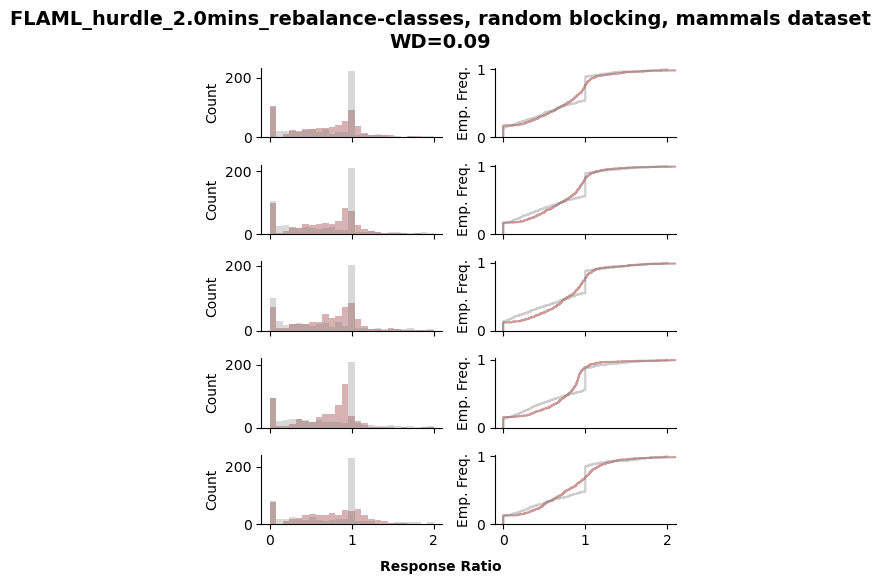

In [30]:
# Looking at histograms/eCDFs of actual/predicted per fold and corresponding Wasserstein distance
max_val = 2
run = runs_to_eval[7]

print(f'Evaluating {run["filename"]}\n')

raw_preds = run['raw_preds']
wds = []

fig, axs = plt.subplots(5, 2, figsize = (5, 6), sharex = True)

for fold in range(0, 5):
    d = raw_preds[raw_preds['fold'] == fold]
    d = d[(d['actual'] <= max_val) & (d['actual'] >= 0)]

    #  histogram
    sns.histplot(data = d, x = 'predicted', stat = 'count', kde = False, legend = False, bins = 25, 
                 color = 'maroon', zorder = 100, alpha = 0.3, ec = None, binrange = (0, max_val), ax = axs[fold, 0])
    sns.histplot(data = d, x = 'actual', stat = 'count', kde = False, legend = False, bins = 25, 
                 color = 'grey', zorder = 100, alpha = 0.3, ec = None, binrange = (0, max_val), ax = axs[fold, 0])

    axs[fold, 0].spines['top'].set_visible(False)
    axs[fold, 0].spines['right'].set_visible(False)

    axs[fold, 0].set_xlim(-0.1, max_val + 0.1)

    axs[fold, 0].set_ylabel('Count')

    #  eCDF
    axs[fold, 1].ecdf(d['predicted'], color = 'maroon', alpha = 0.4)
    axs[fold, 1].ecdf(d['actual'], color = 'grey', alpha = 0.4)

    axs[fold, 1].spines['top'].set_visible(False)
    axs[fold, 1].spines['right'].set_visible(False)

    axs[fold, 1].set_ylim(0, 1 + 0.02)
    
    axs[fold, 1].set_ylabel('Emp. Freq.')

    #  compute Wasserstein distance
    wd = wasserstein_distance(d['actual'], d['predicted'])
    wds.append(wd)

    #  labeling
    axs[fold, 0].set_xlabel(None)

fig.supxlabel('Response Ratio', y = 0.03, size = 10, weight = "bold")

title = f'{run["model_name"].removesuffix("_2.0mins")}, {run["block_type"]} blocking, {run["dataset"]} dataset\nWD={round(np.mean(wds), 3)}'
fig.suptitle(title, y = 0.97, size = 14, weight = "bold")

fig.tight_layout()

# plt.savefig(f'/Users/emiliolr/Desktop/{run["filename"].removesuffix(".csv")}_wass_dist.pdf', bbox_inches = 'tight')
plt.show()

# Checking `scipy` implementation of Wasserstein Distance

According to [Wikipedia](https://en.wikipedia.org/wiki/Wasserstein_metric#Empirical_distributions), the Wasserstein Distance with $p$-norm should be: $$W_p (\{ x_i \}, \{ y_k \}) = \left( \frac{1}{n} \sum_{j = 1}^{N} || x_{(j)} - y_{(j)} || ^ p \right) ^ {\frac{1}{p}},$$ where $\{ x_i \}$ and $\{ y_k \}$ are collections of $N$ samples (i.e., $i, k = 1, ..., N$).

In [25]:
# This is the equation that I think it should be - the difference in corresponding order statistics
def empirical_wd_test(x, y, p = 1):
    x, y = np.sort(x), np.sort(y)

    if p == 1:
        emp_wd = ((1 / len(x)) * np.sum(np.abs(x - y))) ** (1 / p)
    else:
        emp_wd = ((1 / len(x)) * np.sum(np.power(x - y, p))) ** (1 / p)

    return emp_wd

In [28]:
# Our expectation of how WD should be calculated looks to match up with the SciPy implementation!
a = np.random.normal(0, 1, 100)
b = np.random.normal(3, 1, 100)

print(wasserstein_distance(a, b))
print(empirical_wd_test(a, b, p = 1))

3.0269756541790915
3.026975654179093


# Results from recreating the mammal dataset

In [18]:
results = pd.read_csv('../final_results/cross_val_results_all_metrics.csv')

results = results[results['model_name'].str.contains('rf_hurdle')] # | (results['model_name'] == 'pymer_hurdle_wo_rfx_tune-thresh') 
results = results[results['dataset'].isin(['mammals', 'mammals_recreated'])]
results = results[results['block_type'] == 'spatial']

results.sort_values(['metric', 'model_name'])

,metric,mean,standard_deviation,model_name,dataset,date,num_folds,block_type,spatial_spacing,group_col
372,balanced_accuracy_DI-0.05,0.306487,0.005205,rf_hurdle_1.0mins_rebalance-classes,mammals,2025-03-01 21:20:10,5,spatial,5.0,NaN
426,balanced_accuracy_DI-0.05,0.319360,0.018326,rf_hurdle_1.0mins_rebalance-classes,mammals_recreated,2025-03-31 21:43:44,5,spatial,5.0,NaN
379,balanced_accuracy_local_extirpation,0.596491,0.018483,rf_hurdle_1.0mins_rebalance-classes,mammals,2025-03-01 21:20:10,5,spatial,5.0,NaN
433,balanced_accuracy_local_extirpation,0.599313,0.035296,rf_hurdle_1.0mins_rebalance-classes,mammals_recreated,2025-03-31 21:43:44,5,spatial,5.0,NaN
374,mean_absolute_error-1,0.304322,0.022634,rf_hurdle_1.0mins_rebalance-classes,mammals,2025-03-01 21:20:10,5,spatial,5.0,NaN
428,mean_absolute_error-1,0.317704,0.027408,rf_hurdle_1.0mins_rebalance-classes,mammals_recreated,2025-03-31 21:43:44,5,spatial,5.0,NaN
373,mean_absolute_error-inf,0.844122,0.239763,rf_hurdle_1.0mins_rebalance-classes,mammals,2025-03-01 21:20:10,5,spatial,5.0,NaN
427,mean_absolute_error-inf,0.859213,0.250697,rf_hurdle_1.0mins_rebalance-classes,mammals_recreated,2025-03-31 21:43:44,5,spatial,5.0,NaN
377,mean_absolute_percentage_error-0.05,0.707180,0.068992,rf_hurdle_1.0mins_rebalance-classes,mammals,2025-03-01 21:20:10,5,spatial,5.0,NaN
431,mean_absolute_percentage_error-0.05,0.740747,0.092540,rf_hurdle_1.0mins_rebalance-classes,mammals_recreated,2025-03-31 21:43:44,5,spatial,5.0,NaN
